# <B> Anormaly Detection based on AutoEncoder </B>
* Container: codna_pytorch_p310

## AutoEncoder based anomaly detection

- **RaPP** - Novelty Detection with Reconstruction along Projection Pathway <br>
<p align="center">
    <img src="imgs/rapp-f1.png" width="1100" height="300" style="display: block; margin: 0 auto"/>
</p>
<p align="center">
    <img src="imgs/rapp-f2.png" width="1100" height="300" style="display: block; margin: 0 auto"/>
</p>

    * [Ppaer, ICLR 2020] https://openreview.net/attachment?id=HkgeGeBYDB&name=original_pdf
    * [Desc, KOREAN] [RaPP](https://makinarocks.github.io/rapp/)
    * [Supplement #1] [Autoencoder based Anomaly Detection](https://makinarocks.github.io/Autoencoder-based-anomaly-detection/)
    * [Supplement #2] [Reference code (github)](https://github.com/Aiden-Jeon/RaPP)
        

## 0. AutoReload

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = ".."
sys.path.append(os.path.abspath(module_path))

## 1. Parameter store 설정

In [3]:
import boto3
from utils.ssm import parameter_store

In [4]:
strRegionName=boto3.Session().region_name
pm = parameter_store(strRegionName)
strPrefix = pm.get_params(key="PREFIX")

## 3. pramamters for tasks

In [5]:
strAccountId = pm.get_params(key="-".join([strPrefix, "ACCOUNT-ID"]))
strBucketName = pm.get_params(key="-".join([strPrefix, "BUCKET"]))
strExecutionRole = pm.get_params(key="-".join([strPrefix, "SAGEMAKER-ROLE-ARN"]))
strS3DataPath = pm.get_params(key="-".join([strPrefix, "S3-DATA-PATH"]))

In [6]:
print (f"prefix: {strPrefix}")
print (f"account_id: {strAccountId}")
print (f"defaulut_bucket: {strBucketName}")
print (f"sagemaker_role: {strExecutionRole}")
print (f"s3_data_path: {strS3DataPath}")

prefix: ad-ts
account_id: 419974056037
defaulut_bucket: sm-anomaly-detection
sagemaker_role: arn:aws:iam::419974056037:role/service-role/AmazonSageMaker-ExecutionRole-20221206T163436
s3_data_path: s3://sm-anomaly-detection/data


## 1. Data manipulation and visualization

In [7]:
import os
import pandas as pd
from task_utils.util import plot_click_w_fault_and_res, plot_click_w_fault_res_ad, plot_click_w_ad_exp

* load data and derive features

In [8]:
clicks_1T = pd.read_csv(os.path.join(strS3DataPath, "clicks_1T.csv"), parse_dates=["timestamp"]).set_index("timestamp")
clicks_1T["residual"] = clicks_1T['click'] - clicks_1T['user'] 
clicks_1T["fault"] = pd.read_csv(os.path.join(strS3DataPath, "fault_label_1T.csv"), header=None).values[0] ## label
clicks_1T["time"] = [int(str(time).split(" ")[1].split(":")[0]) for time in clicks_1T.index] ## time variable

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/fsspec/registry.py:279: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


In [9]:
print (f'data shape: {clicks_1T.shape}')
print (f'timestamp min: {clicks_1T.index.min()}, max: {clicks_1T.index.max()}')

data shape: (12960, 6)
timestamp min: 2020-07-07 00:00:00, max: 2020-07-15 23:59:00


* visualization

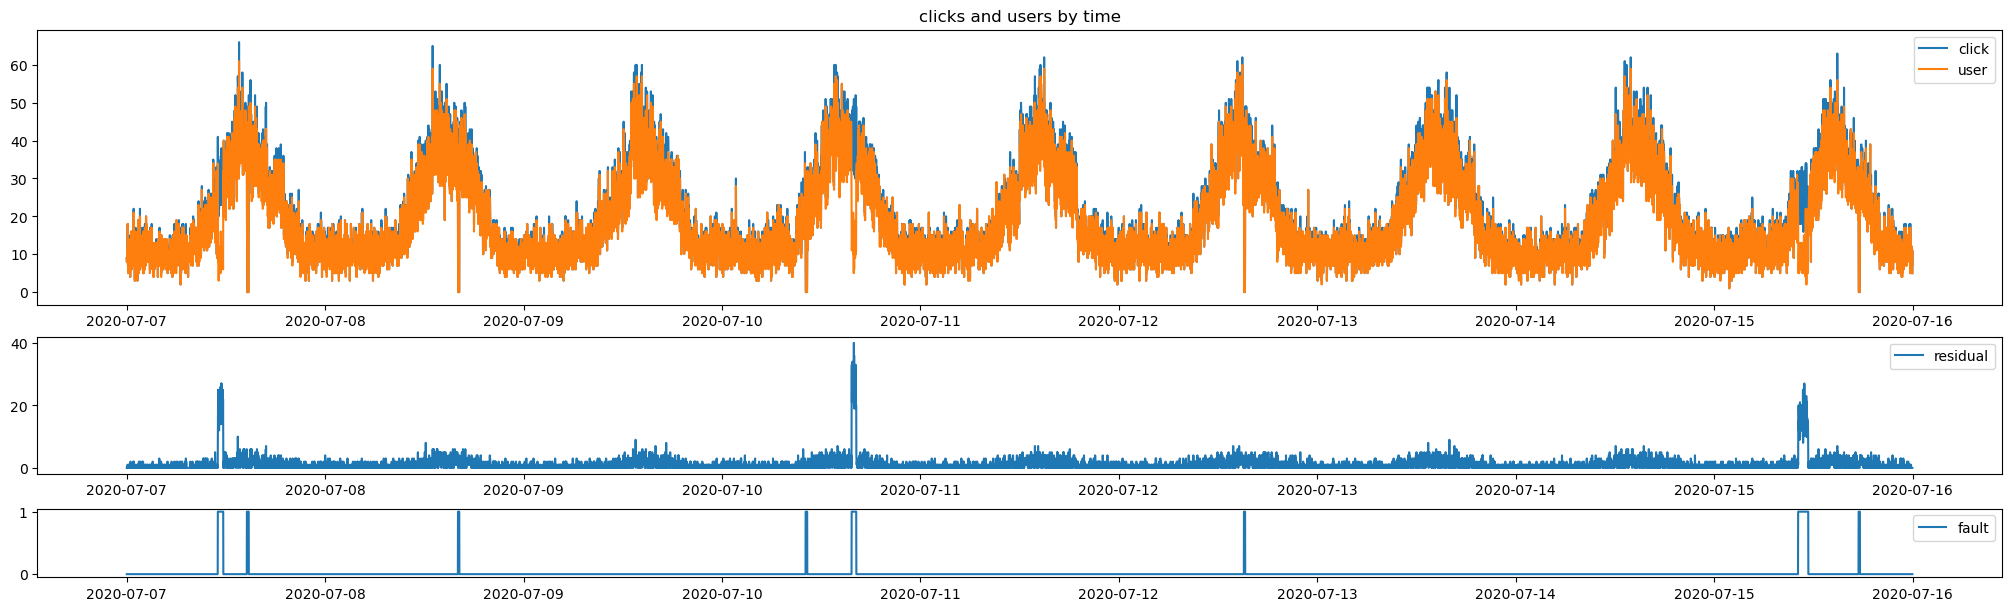

In [10]:
plot_click_w_fault_and_res(clicks_1T)

* upload data to s3 and local

In [11]:
strTrainDataName = "merged_clicks_1T.csv"
clicks_1T.to_csv(os.path.join(strS3DataPath, strTrainDataName), index=True) # to s3
clicks_1T.to_csv(os.path.join("./data", strTrainDataName), index=True) # to local

print (f'train_data_name: {strTrainDataName}')

train_data_name: merged_clicks_1T.csv


## 2. Processing-job for preprocessing

In [12]:
import os
import sagemaker
from sagemaker.pytorch.estimator import PyTorch
from sagemaker.processing import ProcessingInput, ProcessingOutput, FrameworkProcessor

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### Execution based on cloud / local
* params for processing job
    - cloud mode: `local_mode=False`
    - local mode: `local_mode=True`

In [14]:
local_mode = False

if local_mode: 
    strInstanceType = 'local'
    
    import os
    from sagemaker.local import LocalSession
    
    sagemaker_session = LocalSession()
    strDataPath = str(os.path.join("file://", os.getcwd(), "data"))
    
else:
    strInstanceType = "ml.m5.xlarge"
    sagemaker_session = sagemaker.Session()
    strDataPath = strS3DataPath
        
print (f"instance-type: {strInstanceType}")
print (f'role: {strExecutionRole}')
print (f"bucket: {strBucketName}")
print (f"dataset-path: {strDataPath}")
print (f"sagemaker_session: {sagemaker_session}")

instance-type: local
role: arn:aws:iam::419974056037:role/service-role/AmazonSageMaker-ExecutionRole-20221206T163436
bucket: sm-anomaly-detection
dataset-path: /home/ec2-user/SageMaker/sagemaker-immersion-day/advanded/data
sagemaker_session: <sagemaker.local.local_session.LocalSession object at 0x7f4c02af9990>


* Define processing job

In [15]:
dataset_processor = FrameworkProcessor(
    estimator_cls=PyTorch,
    framework_version="2.4.0",
    py_version="py311",
    image_uri=None,
    instance_type=strInstanceType,
    instance_count=1,
    role=strExecutionRole,
    base_job_name="preprocessing", # bucket에 보이는 이름 (pipeline으로 묶으면 pipeline에서 정의한 이름으로 bucket에 보임)
    sagemaker_session=sagemaker_session
)

strProcPrefix = "/opt/ml/processing"

strOutputPath = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "preprocessing",
    "output"
)

nShingleSize = 4

In [16]:
print (f'strOutputPath: {strOutputPath}')
print (f'nShingleSize: {nShingleSize}')

strOutputPath: s3://sm-anomaly-detection/ad-ts/preprocessing/output
nShingleSize: 4


In [17]:
dataset_processor.run(
    #job_name="preprocessing", ## 이걸 넣어야 캐시가 작동함, 안그러면 프로세서의 base_job_name 이름뒤에 날짜 시간이 붙어서 캐시 동작 안함
    #git_config=git_config,
    code='preprocessing.py', #소스 디렉토리 안에서 파일 path
    source_dir= "./src/preprocessing", #현재 파일에서 소스 디렉토리 상대경로 # add processing.py and requirements.txt here
    inputs=[
        ProcessingInput(
            input_name="input-data",
            source=strDataPath,
            destination=os.path.join(strProcPrefix, "input")
        ),
    ],
    outputs=[       
        ProcessingOutput(
            output_name="output-data",
            source=os.path.join(strProcPrefix, "output"),
            destination=strOutputPath
        ),
    ],
    arguments=[
        "--proc_prefix", strProcPrefix, \
        "--shingle_size", str(nShingleSize), \
        "--train_data_name", strTrainDataName
    ]
)

INFO:sagemaker:Creating processing-job with name preprocessing-2024-10-31-03-37-15-298
INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker.local.image:'Docker Compose' is not installed. Proceeding to check for 'docker-compose' CLI.
INFO:sagemaker.local.image:'Docker Compose' found using Docker Compose CLI.
INFO:sagemaker.local.local_session:Starting processing job
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:

time="2024-10-31T03:37:17Z" level=warning msg="/tmp/tmpqewh79cg/docker-compose.yaml: `version` is obsolete"
time="2024-10-31T03:37:17Z" level=warning msg="a network with name sagemaker-local exists but was not created for project \"tmpqewh79cg\".\nSet `external: true` to use an existing network"
 Container nq2mbmw1vs-algo-1-dt3lp  Creating
 Container nq2mbmw1vs-algo-1-dt3lp  Created
Attaching to nq2mbmw1vs-algo-1-dt3lp
nq2mbmw1vs-algo-1-dt3lp  | Received arguments Namespace(proc_prefix='/opt/ml/processing', shingle_size=4, train_data_name='merged_clicks_1T.csv')
nq2mbmw1vs-algo-1-dt3lp  | Data shape: (12960, 6)
nq2mbmw1vs-algo-1-dt3lp  | data_x: (12960, 4), data_y: (12960, 1), data_time: (12960, 1)
nq2mbmw1vs-algo-1-dt3lp  | 12960 (12957, 16)
nq2mbmw1vs-algo-1-dt3lp  | 12960 (12957, 4)
nq2mbmw1vs-algo-1-dt3lp  | 12960 (12957, 4)
nq2mbmw1vs-algo-1-dt3lp  | data_x_scaled_shingle: (12957, 17)
nq2mbmw1vs-algo-1-dt3lp  | data_y_shingle: (12957, 1)
nq2mbmw1vs-algo-1-dt3lp  | check label: [12

INFO:sagemaker.local.image:===== Job Complete =====


* download preprocessed data to local

In [20]:
!aws s3 sync $strOutputPath ./data/preprocessing --quiet

* save params

In [21]:
pm.put_params(key="-".join([strPrefix, "PREP-DATA-PATH"]), value=strOutputPath, overwrite=True)
print (f'S3-PREP-DATA-PATH: {pm.get_params(key="-".join([strPrefix, "PREP-DATA-PATH"]))}')

S3-PREP-DATA-PATH: s3://sm-anomaly-detection/ad-ts/preprocessing/output


## 3. Training-job for anomaly detection

* check gpu

In [22]:
import torch

In [23]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"# DEVICE {i}: {torch.cuda.get_device_name(i)}")
        print("- Memory Usage:")
        print(f"  Allocated: {round(torch.cuda.memory_allocated(i)/1024**3,1)} GB")
        print(f"  Cached:    {round(torch.cuda.memory_reserved(i)/1024**3,1)} GB\n")

else:
    print("# GPU is not available")

# GPU 할당 변경하기
GPU_NUM = 0 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

print ('# Current cuda device: ', torch.cuda.current_device()) # check

# DEVICE 0: NVIDIA A10G
- Memory Usage:
  Allocated: 0.0 GB
  Cached:    0.0 GB

# DEVICE 1: NVIDIA A10G
- Memory Usage:
  Allocated: 0.0 GB
  Cached:    0.0 GB

# DEVICE 2: NVIDIA A10G
- Memory Usage:
  Allocated: 0.0 GB
  Cached:    0.0 GB

# DEVICE 3: NVIDIA A10G
- Memory Usage:
  Allocated: 0.0 GB
  Cached:    0.0 GB

# Current cuda device:  0


In [25]:
import os
from sagemaker.pytorch.estimator import PyTorch
from sagemaker.inputs import TrainingInput

* **Set Up SageMaker Experiment**
    - Create or load [SageMaker Experiment](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) for the example training job. This will create an experiment trial object in SageMaker.
    - **pip instatll sagemaker-experiments**

### Execution based on cloud / local
* params for processing job
    - cloud mode: `local_mode=False`
    - local mode: `local_mode=True`

### Enable warmpool
* `bUseTrainWarmPool = True`

* params for training job

In [26]:
# Set to True to enable SageMaker to run locally
local_mode = True

if local_mode:
    strInstanceType = "local_gpu"
    
    import os
    from sagemaker.local import LocalSession
    
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    
    strLocalDataDir = os.getcwd() + '/data/preprocessing'
    dicDataChannels = {
        "train": f"file://{strLocalDataDir}",
        "validation": f"file://{strLocalDataDir}"
    }
    
else:
    
    strInstanceType = "ml.p3.2xlarge" #"ml.p3.2xlarge"#"ml.g4dn.8xlarge"#"ml.p3.2xlarge", 'ml.p3.16xlarge' , ml.g4dn.8xlarge
    
    sagemaker_session = sagemaker.Session()
    dicDataChannels = {
        "train": pm.get_params(key="-".join([strPrefix, "PREP-DATA-PATH"])),
        "validation": pm.get_params(key="-".join([strPrefix, "PREP-DATA-PATH"]))
    }

dicHyperParams = {
    "epochs":"50",
    "batch_size":"128", 
    "lr":"1e-2",
    "shingle_size":"4",
    "num_features":"4",
    "emb_size":"4",
    "workers":"2"
}

nInstanceCount = 1

bSpotTraining = False
if bSpotTraining:
    nMaxWait = 1*60*60
    nMaxRun = 1*60*60
    
else:
    nMaxWait = None
    nMaxRun = 1*60*60

bUseTrainWarmPool = True ## training image 다운받지 않음, 속도 빨라진다
if bUseTrainWarmPool: nKeepAliveSeconds = 3600 ## 최대 1시간 동안!!, service quota에서 warmpool을 위한 request 필요
else: nKeepAliveSeconds = None
if bSpotTraining:
    bUseTrainWarmPool = False # warmpool은 spot instance 사용시 활용 할 수 없음
    nKeepAliveSeconds = None
    
    
strProcPrefix = "/opt/ml/processing"

strOutputPath = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "training",
    "model-output"
)

strCodeLocation = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "training",
    "backup_codes"
)

num_re = "([0-9\\.]+)(e-?[[01][0-9])?"
metric_definitions = [
    {"Name": "train_loss", "Regex": f"train_loss:{num_re}"},
    {"Name": "train_cos", "Regex": f"train_cos:{num_re}"},
    {"Name": "val_cos", "Regex": f"val_cos:{num_re}"}
]

kwargs = {}

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [27]:
print (f'local_mode: {local_mode}')
print (f'sagemaker_session: {sagemaker_session}')
print (f'strInstanceType: {strInstanceType}')
print (f'dicDataChannels: {dicDataChannels}')
print (f'strOutputPath: {strOutputPath}')

local_mode: True
sagemaker_session: <sagemaker.local.local_session.LocalSession object at 0x7f4c87ae9510>
strInstanceType: local_gpu
dicDataChannels: {'train': 'file:///home/ec2-user/SageMaker/sagemaker-immersion-day/advanded/data/preprocessing', 'validation': 'file:///home/ec2-user/SageMaker/sagemaker-immersion-day/advanded/data/preprocessing'}
strOutputPath: s3://sm-anomaly-detection/ad-ts/training/model-output


* Define training job

In [28]:
estimator = PyTorch(
    entry_point="main.py", # the script we want to run
    source_dir="./src/training", # where our conf/script is
    #git_config=git_config,
    role=strExecutionRole,
    instance_type=strInstanceType,
    instance_count=nInstanceCount,
    image_uri=None,
    framework_version="2.0.0", # version of PyTorch
    py_version="py310",
    volume_size=128,
    code_location=strCodeLocation,
    output_path=strOutputPath,
    disable_profiler=True,
    debugger_hook_config=False,
    hyperparameters=dicHyperParams,
    sagemaker_session=sagemaker_session,
    metric_definitions=metric_definitions,
    max_run=nMaxRun,
    use_spot_instances=bSpotTraining,  # spot instance 활용
    max_wait=nMaxWait,
    keep_alive_period_in_seconds=nKeepAliveSeconds,
    enable_sagemaker_metrics=True,
    #distribution=distribution,
    **kwargs
)

In [29]:
if strInstanceType =='local_gpu': estimator.checkpoint_s3_uri = None

#create_experiment(strExperimentName)
#job_name = create_trial(strExperimentName)
#job_name = "training-ad-4"
estimator.fit(
    inputs=dicDataChannels, 
    #job_name=job_name,
    #experiment_config={
    #  'TrialName': job_name,
    #  'TrialComponentDisplayName': job_name,
    #},
    wait=True,
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-10-31-03-39-08-567
INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker.local.image:'Docker Compose' is not installed. Proceeding to check for 'docker-compose' CLI.
INFO:sagemaker.local.image:'Docker Compose' found using Docker Compose CLI.
INFO:sagemaker.local.local_session:Starting training job
INFO:botocore.

time="2024-10-31T03:39:08Z" level=warning msg="/tmp/tmpwe3q6op0/docker-compose.yaml: `version` is obsolete"
time="2024-10-31T03:39:08Z" level=warning msg="a network with name sagemaker-local exists but was not created for project \"tmpwe3q6op0\".\nSet `external: true` to use an existing network"
 Container n7ixnfdy4c-algo-1-loqnn  Creating
 Container n7ixnfdy4c-algo-1-loqnn  Created
Attaching to n7ixnfdy4c-algo-1-loqnn
n7ixnfdy4c-algo-1-loqnn  | 2024-10-31 03:39:10,433 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
n7ixnfdy4c-algo-1-loqnn  | 2024-10-31 03:39:10,476 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
n7ixnfdy4c-algo-1-loqnn  | 2024-10-31 03:39:10,484 sagemaker-training-toolkit INFO     instance_groups entry not present in resource_config
n7ixnfdy4c-algo-1-loqnn  | 2024-10-31 03:39:10,485 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
n7ixnfdy4c-algo

INFO:sagemaker.local.image:===== Job Complete =====


n7ixnfdy4c-algo-1-loqnn exited with code 0
Aborting on container exit...
 Container n7ixnfdy4c-algo-1-loqnn  Stopping
 Container n7ixnfdy4c-algo-1-loqnn  Stopped


In [30]:
print (f'model data: {estimator.model_data}')

model data: s3://sm-anomaly-detection/ad-ts/training/model-output/pytorch-training-2024-10-31-03-39-08-567/output/model.tar.gz


* save params

In [31]:
pm.put_params(key="-".join([strPrefix, "S3-MODEL-ARTIFACT"]), value=estimator.model_data, overwrite=True)
print (f'S3-MODEL-ARTIFACT: {pm.get_params(key="-".join([strPrefix, "S3-MODEL-ARTIFACT"]))}')

S3-MODEL-ARTIFACT: s3://sm-anomaly-detection/ad-ts/training/model-output/pytorch-training-2024-10-31-03-39-08-567/output/model.tar.gz


### SageMaker Distributed Data Parallel (SMDDP)
* code conversion to use SMDDP (`./src/trating/main_ddp.py`) 
    - warpping model with ddp
    - local rank
    - data loader (distributed sampler)
* `distribution={"smdistributed": {"dataparallel": {"enabled": True}}}`

#distribution = {"torch_distributed": {"enabled": True}} 
#distribution = {"pytorchddp": {"enabled": True}} 


In [33]:
# Set to True to enable SageMaker to run locally
local_mode = True

if local_mode:
    strInstanceType = "local_gpu"
    
    import os
    from sagemaker.local import LocalSession
    
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    
    strLocalDataDir = os.getcwd() + '/data/preprocessing'
    dicDataChannels = {
        "train": f"file://{strLocalDataDir}",
        "validation": f"file://{strLocalDataDir}"
    }
    
else:
    
    strInstanceType = "ml.p3.2xlarge" #"ml.p3.2xlarge"#"ml.g4dn.8xlarge"#"ml.p3.2xlarge", 'ml.p3.16xlarge' , ml.g4dn.8xlarge
    
    sagemaker_session = sagemaker.Session()
    dicDataChannels = {
        "train": pm.get_params(key="-".join([strPrefix, "PREP-DATA-PATH"])),
        "validation": pm.get_params(key="-".join([strPrefix, "PREP-DATA-PATH"]))
    }

dicHyperParams = {
    "epochs":"50",
    "batch_size":"128", 
    "lr":"1e-2",
    "shingle_size":"4",
    "num_features":"4",
    "emb_size":"4",
    "workers":"2"
}

nInstanceCount = 1

bSpotTraining = False
if bSpotTraining:
    nMaxWait = 1*60*60
    nMaxRun = 1*60*60
    
else:
    nMaxWait = None
    nMaxRun = 1*60*60

bUseTrainWarmPool = True ## training image 다운받지 않음, 속도 빨라진다
if bUseTrainWarmPool: nKeepAliveSeconds = 3600 ## 최대 1시간 동안!!, service quota에서 warmpool을 위한 request 필요
else: nKeepAliveSeconds = None
if bSpotTraining:
    bUseTrainWarmPool = False # warmpool은 spot instance 사용시 활용 할 수 없음
    nKeepAliveSeconds = None
    
    
strProcPrefix = "/opt/ml/processing"

strOutputPath = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "training",
    "model-output"
)

strCodeLocation = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "training",
    "backup_codes"
)

#distribution={"smdistributed": {"dataparallel": {"enabled": True}}}
distribution={"torch_distributed": {"enabled": True}}

num_re = "([0-9\\.]+)(e-?[[01][0-9])?"
metric_definitions = [
    {"Name": "train_loss", "Regex": f"train_loss:{num_re}"},
    {"Name": "train_cos", "Regex": f"train_cos:{num_re}"},
    {"Name": "val_cos", "Regex": f"val_cos:{num_re}"}
]

kwargs = {}

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [34]:
estimator = PyTorch(
    entry_point="main_ddp.py", # the script we want to run
    source_dir="./src/training", # where our conf/script is
    #git_config=git_config,
    role=strExecutionRole,
    instance_type=strInstanceType,
    instance_count=nInstanceCount,
    image_uri=None,
    framework_version="2.0.0", # version of PyTorch
    py_version="py310",
    volume_size=128,
    code_location=strCodeLocation,
    output_path=strOutputPath,
    disable_profiler=True,
    debugger_hook_config=False,
    hyperparameters=dicHyperParams,
    sagemaker_session=sagemaker_session,
    metric_definitions=metric_definitions,
    max_run=nMaxRun,
    use_spot_instances=bSpotTraining,  # spot instance 활용
    max_wait=nMaxWait,
    keep_alive_period_in_seconds=nKeepAliveSeconds,
    enable_sagemaker_metrics=True,
    distribution=distribution,
    **kwargs
)

if strInstanceType =='local_gpu':
    estimator.checkpoint_s3_uri = None

estimator.fit(
    inputs=dicDataChannels,
    wait=True,
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-10-31-03-42-02-859
INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker.local.image:'Docker Compose' is not installed. Proceeding to check for 'docker-compose' CLI.
INFO:sagemaker.local.image:'Docker Compose' found using Docker Compose CLI.
INFO:sagemaker.local.local_session:Starting training job
INFO:botocore.

time="2024-10-31T03:42:02Z" level=warning msg="/tmp/tmp60nwowoz/docker-compose.yaml: `version` is obsolete"
time="2024-10-31T03:42:02Z" level=warning msg="a network with name sagemaker-local exists but was not created for project \"tmp60nwowoz\".\nSet `external: true` to use an existing network"
 Container tknfpdhr2u-algo-1-9y509  Creating
 Container tknfpdhr2u-algo-1-9y509  Created
Attaching to tknfpdhr2u-algo-1-9y509
tknfpdhr2u-algo-1-9y509  | 2024-10-31 03:42:04,637 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
tknfpdhr2u-algo-1-9y509  | 2024-10-31 03:42:04,681 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
tknfpdhr2u-algo-1-9y509  | 2024-10-31 03:42:04,689 sagemaker-training-toolkit INFO     instance_groups entry not present in resource_config
tknfpdhr2u-algo-1-9y509  | 2024-10-31 03:42:04,690 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
tknfpdhr2u-algo

INFO:sagemaker.local.image:===== Job Complete =====


tknfpdhr2u-algo-1-9y509 exited with code 0
Aborting on container exit...
 Container tknfpdhr2u-algo-1-9y509  Stopping
 Container tknfpdhr2u-algo-1-9y509  Stopped


### SageMaker Experiments using MLFlow
* code conversion to use Experiments (`./src/trating/main_ddp_mlflow_exp.py`) 

In [35]:
import mlflow
from time import strftime

In [36]:
create_date = strftime("%m%d-%H%M%s")
tracking_server_arn = pm.get_params(key="-".join([strPrefix, "MLFLOW-TRACKING-SERVER-ARN"]))
mlflow_exp_name = f'run-{strPrefix}-exp-{create_date}'
mlflow.create_experiment(mlflow_exp_name)

print (f'tracking_server_arn: {tracking_server_arn}')
print (f'mlflow_exp_name: {mlflow_exp_name}')

tracking_server_arn: arn:aws:sagemaker:us-west-2:419974056037:mlflow-tracking-server/mlflow-tracking-anomaly-detection
mlflow_exp_name: run-ad-ts-exp-1031-03431730346230


In [37]:
# Set to True to enable SageMaker to run locally
local_mode = False

if local_mode:
    strInstanceType = "local_gpu"
    
    import os
    from sagemaker.local import LocalSession
    
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    
    strLocalDataDir = os.getcwd() + '/data/preprocessing'
    dicDataChannels = {
        "train": f"file://{strLocalDataDir}",
        "validation": f"file://{strLocalDataDir}"
    }
    
else:
    
    strInstanceType = "ml.p3.2xlarge" #"ml.p3.2xlarge"#"ml.g4dn.8xlarge"#"ml.p3.2xlarge", 'ml.p3.16xlarge' , ml.g4dn.8xlarge
    
    sagemaker_session = sagemaker.Session()
    dicDataChannels = {
        "train": pm.get_params(key="-".join([strPrefix, "PREP-DATA-PATH"])),
        "validation": pm.get_params(key="-".join([strPrefix, "PREP-DATA-PATH"]))
    }

dicHyperParams = {
    "epochs":"50",
    "batch_size":"128", 
    "lr":"1e-2",
    "shingle_size":"4",
    "num_features":"4",
    "emb_size":"4",
    "workers":"2"
}

nInstanceCount = 1

bSpotTraining = False
if bSpotTraining:
    nMaxWait = 1*60*60
    nMaxRun = 1*60*60
    
else:
    nMaxWait = None
    nMaxRun = 1*60*60

bUseTrainWarmPool = True ## training image 다운받지 않음, 속도 빨라진다
if bUseTrainWarmPool: nKeepAliveSeconds = 3600 ## 최대 1시간 동안!!, service quota에서 warmpool을 위한 request 필요
else: nKeepAliveSeconds = None
if bSpotTraining:
    bUseTrainWarmPool = False # warmpool은 spot instance 사용시 활용 할 수 없음
    nKeepAliveSeconds = None
    
    
strProcPrefix = "/opt/ml/processing"

strOutputPath = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "training",
    "model-output"
)

strCodeLocation = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "training",
    "backup_codes"
)

#distribution={"smdistributed": {"dataparallel": {"enabled": True}}}
distribution={"torch_distributed": {"enabled": True}}

environment={
    "MLFLOW_TRACKING_ARN": tracking_server_arn,
    "EXPERIMENT_NAME": mlflow_exp_name
}
strExperimentName = '-'.join([strPrefix, "experiments-test"])
create_date = strftime("%m%d-%H%M%s")
strRunName = f'run-smimd-ddp-{create_date}'

num_re = "([0-9\\.]+)(e-?[[01][0-9])?"
metric_definitions = [
    {"Name": "train_loss", "Regex": f"train_loss:{num_re}"},
    {"Name": "train_cos", "Regex": f"train_cos:{num_re}"},
    {"Name": "val_cos", "Regex": f"val_cos:{num_re}"}
]

kwargs = {}

In [38]:
environment={
    "MLFLOW_TRACKING_ARN": tracking_server_arn,
    "EXPERIMENT_NAME": mlflow_exp_name
}

estimator = PyTorch(
    entry_point="main_ddp_mlflow_exp.py", # the script we want to run
    source_dir="./src/training", # where our conf/script is
    #git_config=git_config,
    role=strExecutionRole,
    instance_type=strInstanceType,
    instance_count=nInstanceCount,
    image_uri=None,
    framework_version="2.0.0", # version of PyTorch
    py_version="py310",
    volume_size=128,
    code_location=strCodeLocation,
    output_path=strOutputPath,
    disable_profiler=True,
    debugger_hook_config=False,
    hyperparameters=dicHyperParams,
    sagemaker_session=sagemaker_session,
    metric_definitions=metric_definitions,
    max_run=nMaxRun,
    use_spot_instances=bSpotTraining,  # spot instance 활용
    max_wait=nMaxWait,
    keep_alive_period_in_seconds=nKeepAliveSeconds,
    enable_sagemaker_metrics=True,
    distribution=distribution,
    environment=environment,
    **kwargs
)

if strInstanceType =='local_gpu':
    estimator.checkpoint_s3_uri = None

estimator.fit(
    inputs=dicDataChannels,
    wait=True,
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-10-31-03-43-51-714


2024-10-31 03:43:56 Starting - Found matching resource for reuse
2024-10-31 03:43:56 Downloading - Downloading input data..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-10-31 03:44:07,535 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-10-31 03:44:07,553 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-10-31 03:44:07,564 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-10-31 03:44:07,566 sagemaker_pytorch_container.training INFO     Invoking TorchDistributed...
2024-10-31 03:44:07,566 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-10-31 03:44:09,310 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.10 -m pip install -r requirements.txt
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 45

### SageMaker Experiments (will be deplecated)
* code conversion to use Experiments (`./src/trating/main_ddp_exp.py`) 

In [ ]:
from time import strftime
from sagemaker.experiments.run import Run

In [ ]:
# Set to True to enable SageMaker to run locally
local_mode = False

if local_mode:
    strInstanceType = "local_gpu"
    
    import os
    from sagemaker.local import LocalSession
    
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    
    strLocalDataDir = os.getcwd() + '/data/preprocessing'
    dicDataChannels = {
        "train": f"file://{strLocalDataDir}",
        "validation": f"file://{strLocalDataDir}"
    }
    
else:
    
    strInstanceType = "ml.p3.2xlarge" #"ml.p3.2xlarge"#"ml.g4dn.8xlarge"#"ml.p3.2xlarge", 'ml.p3.16xlarge' , ml.g4dn.8xlarge
    
    sagemaker_session = sagemaker.Session()
    dicDataChannels = {
        "train": pm.get_params(key="-".join([strPrefix, "PREP-DATA-PATH"])),
        "validation": pm.get_params(key="-".join([strPrefix, "PREP-DATA-PATH"]))
    }

dicHyperParams = {
    "epochs":"50",
    "batch_size":"128", 
    "lr":"1e-2",
    "shingle_size":"4",
    "num_features":"4",
    "emb_size":"4",
    "workers":"2"
}

nInstanceCount = 1

bSpotTraining = False
if bSpotTraining:
    nMaxWait = 1*60*60
    nMaxRun = 1*60*60
    
else:
    nMaxWait = None
    nMaxRun = 1*60*60

bUseTrainWarmPool = True ## training image 다운받지 않음, 속도 빨라진다
if bUseTrainWarmPool: nKeepAliveSeconds = 3600 ## 최대 1시간 동안!!, service quota에서 warmpool을 위한 request 필요
else: nKeepAliveSeconds = None
if bSpotTraining:
    bUseTrainWarmPool = False # warmpool은 spot instance 사용시 활용 할 수 없음
    nKeepAliveSeconds = None
    
    
strProcPrefix = "/opt/ml/processing"

strOutputPath = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "training",
    "model-output"
)

strCodeLocation = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "training",
    "backup_codes"
)

distribution={"smdistributed": {"dataparallel": {"enabled": True}}}

strExperimentName = '-'.join([strPrefix, "experiments-test"])
create_date = strftime("%m%d-%H%M%s")
strRunName = f'run-smimd-ddp-{create_date}'

num_re = "([0-9\\.]+)(e-?[[01][0-9])?"
metric_definitions = [
    {"Name": "train_loss", "Regex": f"train_loss:{num_re}"},
    {"Name": "train_cos", "Regex": f"train_cos:{num_re}"},
    {"Name": "val_cos", "Regex": f"val_cos:{num_re}"}
]

kwargs = {}

In [ ]:
with Run(
    experiment_name=strExperimentName,
    run_name=strRunName,
    sagemaker_session=sagemaker_session
) as run:

    estimator = PyTorch(
        entry_point="main_ddp_exp.py", # the script we want to run
        source_dir="./src/training", # where our conf/script is
        #git_config=git_config,
        role=strExecutionRole,
        instance_type=strInstanceType,
        instance_count=nInstanceCount,
        image_uri=None,
        framework_version="2.0.0", # version of PyTorch
        py_version="py310",
        volume_size=128,
        code_location=strCodeLocation,
        output_path=strOutputPath,
        disable_profiler=True,
        debugger_hook_config=False,
        hyperparameters=dicHyperParams,
        sagemaker_session=sagemaker_session,
        metric_definitions=metric_definitions,
        max_run=nMaxRun,
        use_spot_instances=bSpotTraining,  # spot instance 활용
        max_wait=nMaxWait,
        keep_alive_period_in_seconds=nKeepAliveSeconds,
        enable_sagemaker_metrics=True,
        distribution=distribution,
        environment=,
        **kwargs
    )

    if strInstanceType =='local_gpu':
        estimator.checkpoint_s3_uri = None

    estimator.fit(
        inputs=dicDataChannels,
        wait=True,
    )

### SageMaker HyperparameterTuner

In [ ]:
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter

In [ ]:
# Set to True to enable SageMaker to run locally
local_mode = False

if local_mode:
    strInstanceType = "local_gpu"
    
    import os
    from sagemaker.local import LocalSession
    
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    
    strLocalDataDir = os.getcwd() + '/data/preprocessing'
    dicDataChannels = {
        "train": f"file://{strLocalDataDir}",
        "validation": f"file://{strLocalDataDir}"
    }
    
else:
    
    strInstanceType = "ml.g5.2xlarge" #"ml.p3.2xlarge"#"ml.g4dn.8xlarge"#"ml.p3.2xlarge", 'ml.p3.16xlarge' , ml.g4dn.8xlarge
    
    sagemaker_session = sagemaker.Session()
    dicDataChannels = {
        "train": pm.get_params(key="-".join([strPrefix, "PREP-DATA-PATH"])),
        "validation": pm.get_params(key="-".join([strPrefix, "PREP-DATA-PATH"]))
    }

dicHyperParams = {
    "epochs":"50",
    "batch_size":"128", 
    "lr":"1e-2",
    "shingle_size":"4",
    "num_features":"4",
    "emb_size":"4",
    "workers":"2"
}

nInstanceCount = 1

bSpotTraining = False
if bSpotTraining:
    nMaxWait = 1*60*60
    nMaxRun = 1*60*60
    
else:
    nMaxWait = None
    nMaxRun = 1*60*60

bUseTrainWarmPool = True ## training image 다운받지 않음, 속도 빨라진다
if bUseTrainWarmPool: nKeepAliveSeconds = 3600 ## 최대 1시간 동안!!, service quota에서 warmpool을 위한 request 필요
else: nKeepAliveSeconds = None
if bSpotTraining:
    bUseTrainWarmPool = False # warmpool은 spot instance 사용시 활용 할 수 없음
    nKeepAliveSeconds = None
    
    
strProcPrefix = "/opt/ml/processing"

strOutputPath = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "training",
    "model-output"
)

strCodeLocation = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "training",
    "backup_codes"
)

distribution={"smdistributed": {"dataparallel": {"enabled": True}}}

num_re = "([0-9\\.]+)(e-?[[01][0-9])?"
metric_definitions = [
    {"Name": "train_loss", "Regex": f"train_loss:{num_re}"},
    {"Name": "train_cos", "Regex": f"train_cos:{num_re}"},
    {"Name": "val_cos", "Regex": f"val_cos:{num_re}"}
]

## hyperparam tuner
base_tuning_job_name = '-'.join([strPrefix, "hyperparam-test"])

#experiments
experiment_name = '-'.join([strPrefix, "exp-hyperparam"])
create_date = strftime("%m%d-%H%M%s")
strRunName = f'run-smimd-ddp-hyperparam-{create_date}'

tuner_args = dict(
    objective_metric_name="val_cos",
    objective_type="Maximize", #Minimize
    metric_definitions=metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    early_stopping_type="Auto",
)

kwargs = {}

In [ ]:
estimator = PyTorch(
    entry_point="main_ddp.py", # the script we want to run
    source_dir="./src/training", # where our conf/script is
    #git_config=git_config,
    role=strExecutionRole,
    instance_type=strInstanceType,
    instance_count=nInstanceCount,
    image_uri=None,
    framework_version="2.0.0", # version of PyTorch
    py_version="py310",
    volume_size=128,
    code_location=strCodeLocation,
    output_path=strOutputPath,
    disable_profiler=True,
    debugger_hook_config=False,
    hyperparameters=dicHyperParams,
    sagemaker_session=sagemaker_session,
    metric_definitions=metric_definitions,
    max_run=nMaxRun,
    use_spot_instances=bSpotTraining,  # spot instance 활용
    max_wait=nMaxWait,
    keep_alive_period_in_seconds=nKeepAliveSeconds,
    enable_sagemaker_metrics=True,
    distribution=distribution,
    environment={"AWS_REGION": strRegionName},
    **kwargs
)

# Define a Hyperparameter Tuning Job
tuner = HyperparameterTuner(
    estimator=estimator,
    hyperparameter_ranges={
        "batch_size": IntegerParameter(50, 100, "Auto"),
    },
    base_tuning_job_name=base_tuning_job_name,
    **tuner_args,
)

In [ ]:
with Run(
    experiment_name=experiment_name,
    run_name=strRunName,
    sagemaker_session=sagemaker_session
) as run:

    if strInstanceType =='local_gpu':
        estimator.checkpoint_s3_uri = None

    # Start the tuning job with the specified input data
    tuner.fit(
        inputs=dicDataChannels,
        wait=True
    )